## XAI

In [49]:
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration

# Load the saved processor and model
save_path = "/kaggle/working/finetuned_paligemma_riscm_final"

processor = PaliGemmaProcessor.from_pretrained(save_path)
model = PaliGemmaForConditionalGeneration.from_pretrained(save_path, torch_dtype=torch.bfloat16).to("cuda")
model.eval()

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

PaliGemmaForConditionalGeneration(
  (model): PaliGemmaModel(
    (vision_tower): SiglipVisionModel(
      (vision_model): SiglipVisionTransformer(
        (embeddings): SiglipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
          (position_embedding): Embedding(256, 1152)
        )
        (encoder): SiglipEncoder(
          (layers): ModuleList(
            (0-26): 27 x SiglipEncoderLayer(
              (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
              (self_attn): SiglipAttention(
                (k_proj): lora.Linear(
                  (base_layer): Linear(in_features=1152, out_features=1152, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Identity()
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1152, out_features=8, bias=False)
                  )
                  (lora_B):

In [18]:
!pip install -q captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 34.8 MB/s eta 0:00:0000:01


In [19]:
import torch
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
from transformers import PaliGemmaForConditionalGeneration, PaliGemmaProcessor
from PIL import Image

from transformers import PaliGemmaForConditionalGeneration, PaliGemmaProcessor
from peft import PeftModel
import torch

# Step 1: Load the base model from Hugging Face (required for full architecture)
base_model_id = "google/paligemma-3b-pt-224"
base_model = PaliGemmaForConditionalGeneration.from_pretrained(
    base_model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16
)

# Step 2: Load processor (tokenizer + image processor)
processor = PaliGemmaProcessor.from_pretrained(base_model_id)

# Step 3: Load LoRA adapter from the saved directory
adapter_path = "/kaggle/input/paligemma"
model = PeftModel.from_pretrained(base_model, adapter_path).to("cuda").eval()

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

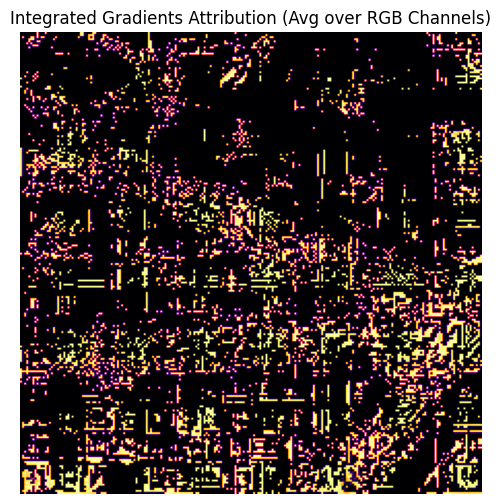

In [44]:
import torch
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# 1. Define Prompt and Test Image
prompt = "<image> explain the layout of the terrain and infrastructure."
example = test_ds[15]  # Use a representative test image and caption
image = example["image"]
caption = example["caption"]

# 2. Preprocess Inputs
model_inputs = processor(images=image, text=prompt, return_tensors="pt").to(model.device)
pixel_values = model_inputs["pixel_values"]
input_ids = model_inputs["input_ids"]
attention_mask = model_inputs["attention_mask"]

# 3. Create baseline (black image)
baseline_pixel = torch.zeros_like(pixel_values)

# 4. Define forward function for Captum
def forward_func(pixel_input):
    outputs = model(
        pixel_values=pixel_input,
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    logits = outputs.logits  # [batch_size, seq_len, vocab]
    target_token_id = processor.tokenizer.encode("sand", add_special_tokens=False)[0]
    return logits[:, -1, target_token_id]  # attribution for final token prediction

# 5. Run Integrated Gradients with safe memory usage
ig = IntegratedGradients(forward_func)

attributions, delta = ig.attribute(
    inputs=pixel_values,
    baselines=baseline_pixel,
    target=None,
    return_convergence_delta=True,
    n_steps=20,  # reduce from default 50
    internal_batch_size=1
)

# 6. Visualize per-channel attribution map
attr = attributions.squeeze().detach().cpu()
attr_map = attr.mean(dim=0)  # mean across RGB channels

plt.figure(figsize=(6, 6))
plt.imshow(to_pil_image(attr_map), cmap="inferno")
plt.title("Integrated Gradients Attribution (Avg over RGB Channels)")
plt.axis("off")
plt.show()

Occlusion attribution:   0%|          | 0/1850 [00:00<?, ?it/s]

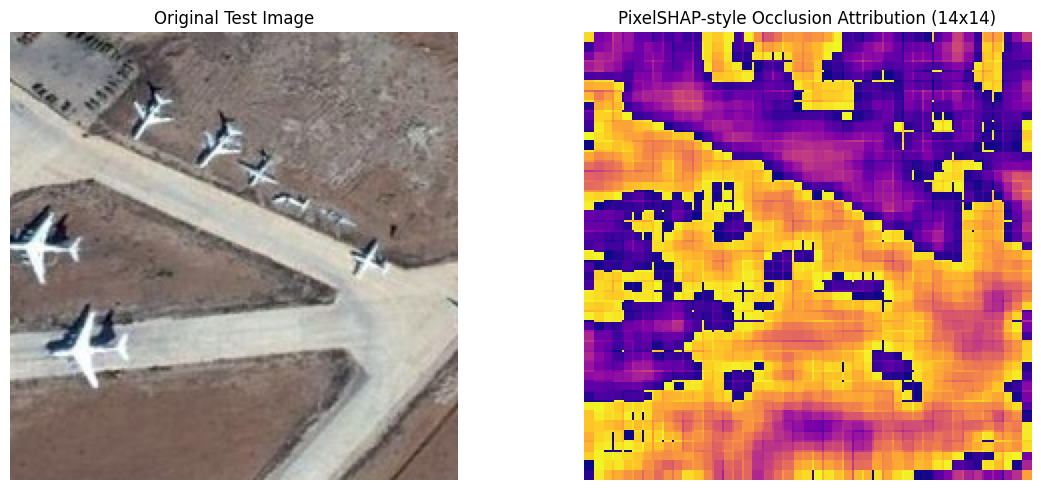

In [56]:
from captum.attr import Occlusion

# 1. Define correct forward function with multiple inputs
def forward_func_occlusion(pixel_input, input_ids, attention_mask):
    outputs = model(
        pixel_values=pixel_input,
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    target_token_id = processor.tokenizer.encode("sand", add_special_tokens=False)[0]
    return outputs.logits[:, -1, target_token_id]

# 2. Initialize Occlusion attribution
occlusion = Occlusion(forward_func_occlusion)

# 3. Run occlusion with correct args
attributions_occ = occlusion.attribute(
    inputs=pixel_values,
    sliding_window_shapes=(3, 14, 14),     # channels, height, width
    strides=(3, 5, 5),                     # smoother occlusion
    baselines=baseline_pixel,
    target=None,                          # optional since forward returns specific index
    additional_forward_args=(input_ids, attention_mask),
    show_progress=True
)

# 4. Visualize
attr_map_occ = attributions_occ.squeeze().cpu().mean(dim=0)  # average over RGB channels

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Test Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(to_pil_image(attr_map_occ), cmap="plasma")
plt.title("PixelSHAP-style Occlusion Attribution (14x14)")
plt.axis("off")
plt.tight_layout()
plt.show()

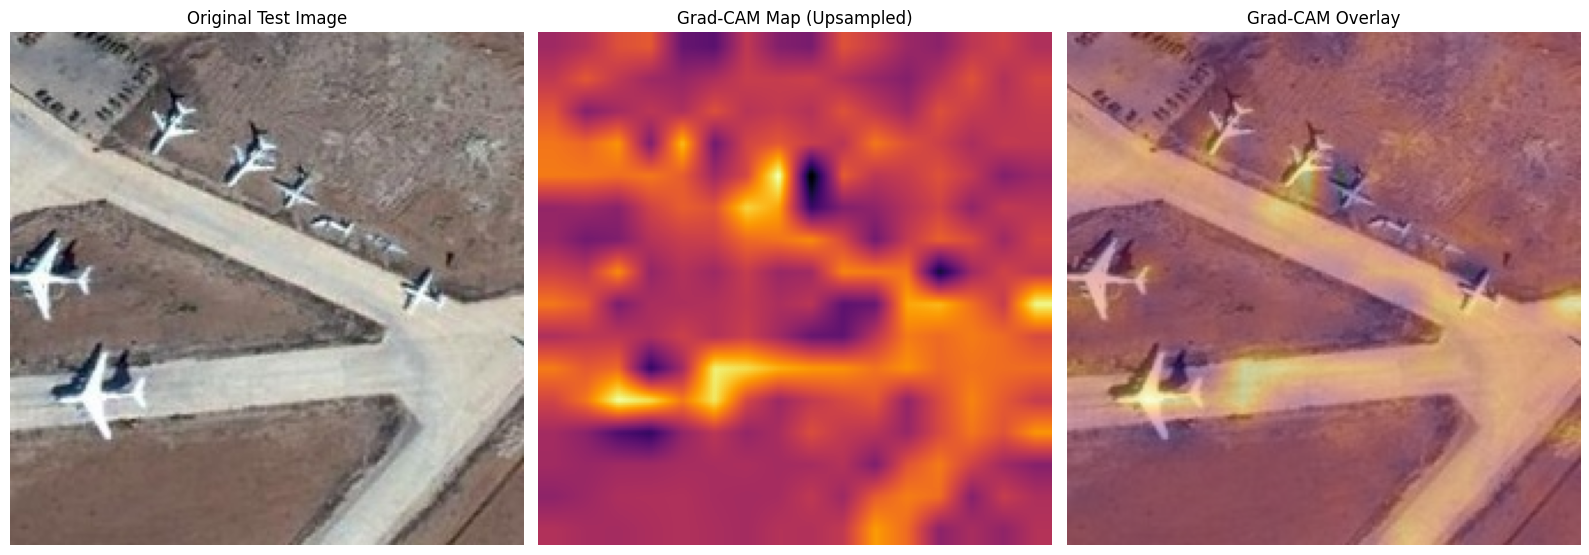

In [85]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from captum.attr import LayerGradCam
from PIL import Image
import numpy as np

# Example selection
example = test_ds[15]
image = example["image"]
caption = example["caption"]
prompt = "<image> explain the layout of the terrain and infrastructure."

# 1. Prepare model input
inputs = processor(images=image, text=prompt, return_tensors="pt").to(model.device)
pixel_values = inputs["pixel_values"]
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

# 2. Select the patch embedding convolutional layer
target_layer = model.base_model.model.vision_tower.vision_model.embeddings.patch_embedding

# 3. Custom forward for target token (can be any other important word)
target_token = "sand"
target_token_id = processor.tokenizer.encode(target_token, add_special_tokens=False)[0]

def forward_func(pixel_values):
    outputs = model(pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask)
    return outputs.logits[:, -1, target_token_id]

# 4. Run Grad-CAM
gradcam = LayerGradCam(forward_func, target_layer)
attributions = gradcam.attribute(pixel_values, target=None)

# 5. Reduce across channel dimension, if needed (should be [B, C, H, W])
if attributions.dim() == 4:
    cam = attributions[0].mean(0)   # [H, W]
else:
    cam = attributions[0]           # [H, W] (already reduced)

# 6. Upsample Grad-CAM map to match original image size
cam = cam.unsqueeze(0).unsqueeze(0).to(torch.float32)  # [1,1,H,W]
cam_upsampled = F.interpolate(cam, size=(image.size[1], image.size[0]), mode="bilinear", align_corners=False)
cam_upsampled = cam_upsampled.squeeze().detach().cpu().numpy()
cam_norm = (cam_upsampled - np.nanmin(cam_upsampled)) / (np.nanmax(cam_upsampled) - np.nanmin(cam_upsampled) + 1e-8)

# 7. Overlay on image
image_np = np.array(image.convert("RGB")) / 255.0
heatmap = plt.get_cmap("inferno")(cam_norm)[..., :3]
overlay = (0.6 * image_np + 0.4 * heatmap)
overlay = np.clip(overlay, 0, 1)

# 8. Plot side-by-side
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

axs[0].imshow(image_np)
axs[0].set_title("Original Test Image")
axs[0].axis("off")

axs[1].imshow(cam_norm, cmap="inferno")
axs[1].set_title("Grad-CAM Map (Upsampled)")
axs[1].axis("off")

axs[2].imshow(overlay)
axs[2].set_title("Grad-CAM Overlay")
axs[2].axis("off")

plt.tight_layout()
plt.show()